In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import random
import re

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
import torchtext.vocab as vocab

from transformers import get_linear_schedule_with_warmup

import gensim

# internal imports
import evaluation.evaluate as val
from modelling import bert, util
import visualization as vis

In [2]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [3]:
# chart styling parameters
is_custom_style = False
style_kwargs = vis.get_style_kwargs(is_custom_style=is_custom_style)

Download pretrained model

In [4]:
glove = vocab.GloVe(name='6B', dim=300)

w2v_path = '/Users/mariakozlova/gensim-data/word2vec-google-news-300/word2vec-google-news-300'
w2v_eng = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)

## Get and explore data

In [5]:
# https://zenodo.org/records/3355823
file_name = "ecommerceDataset.csv"
data = pd.read_csv(file_name, header=None)
data.columns = ["category", "description"]

print("Rows, cols:", data.shape)
data.head(10)

Rows, cols: (50425, 2)


category                                        description
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...
4  Household  Incredible Gifts India Wooden Happy Birthday U...
5  Household  Pitaara Box Romantic Venice Canvas Painting 6m...
6  Household  Paper Plane Design Starry Night Vangoh Wall Ar...
7  Household  Pitaara Box Romantic Venice Canvas Painting 6m...
8  Household  SAF 'Ganesh Modern Art Print' Painting (Synthe...
9  Household  Paintings Villa UV Textured Modern Art Print F...

Category distribution

In [6]:
data["category"].value_counts()

Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: category, dtype: int64

Description examples

In [7]:
for category in data["category"].unique():
    row_example = data[data["category"] == category].sample(n=100).iloc[0]
    print(f"CATEGORY: {row_example['category']}\nDESCRIPTION:\n{row_example['description']}\n\n")

CATEGORY: Household
DESCRIPTION:
Riedel VINUM Cognac Glasses, Set of 2 Size:Set of 2                                                                                 |                            Style:Cognac   6416/71 Features: -Hennessy cognac glass.-Lead crystal.-Gift boxed.-Dishwasher safe. Dimensions: -7.25'' H. Collection: -Vinum collection.


CATEGORY: Books
DESCRIPTION:
Illustrated Guide to Indian Accounting Standards (Ind AS) (5th Edition May 2018) As Amended by Companies (Indian Accounting Standards) (Amendment) Rules 2018****A Comprehensive commentary on Ind AS with more than 200 illustrations, charts and case studies, Detailed comparative analysis of Ind AS and AS, Comparison of Ind AS and AS with IFRS and US GAAP, Detailed Comparative analysis of Ind AS, AS and ICDS, Analysis of impact of Ind AS in various industry sectors, Convergence of Ind AS with IFRS,**** Also Incorporating: NEW IND AS 115 - REVENUE FROM CONTRACTS WITH CUSTOMERS WITH ILLUSTRATIONS


CATEGORY: Clothing &

Handling empty values

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     50425 non-null  object
 1   description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [9]:
data[data["description"].isna()]

category description
39330  Clothing & Accessories         NaN

In [10]:
data.dropna(inplace=True)

## Handle duplicates

In [11]:
repeated_messages = data \
    .groupby("description", as_index=False) \
    .agg(
        n_repeats=("category", "count"),
        n_unique_categories=("category", lambda x: len(np.unique(x)))
    )

assert all(repeated_messages["n_unique_categories"] == 1), \
    f"Repeated descriptions with non-unique categories: " + \
    f"{repeated_messages[repeated_messages['n_unique_categories']] > 1}"

repeated_messages = repeated_messages[repeated_messages["n_repeats"] > 1]

print(f"Count of repeated messages (unique): {repeated_messages.shape[0]}")
print(f"Total number: {repeated_messages['n_repeats'].sum()} out of {data.shape[0]}")

repeated_messages.head(10)

Count of repeated messages (unique): 13979
Total number: 36601 out of 50424


description  n_repeats  \
2   # The Silky Beans 2 KG Premium Bean Bag Filler...          4   
3   # The Silky Beans 500 Gram Premium A-Grade for...          4   
4                                            #Horror           4   
7   (CERTIFIED REFURBISHED) HP DeskJet 2131 All-in...          2   
8   (CERTIFIED REFURBISHED) Logitech K230 Wireless...          2   
11  (CERTIFIED REFURBISHED) Philips BT 106 Bluetoo...          2   
17  .42x HD Super Wide Angle Panoramic Macro Fishe...          2   
18  0-Degree Electrical Socket Cover for Indian Pl...          2   
20  0-Degree Women's Ankle Length Premium Cotton M...          2   
21  1 12 4PCS Gold Metal Door Knocker Lock Doorpla...          2   

    n_unique_categories  
2                     1  
3                     1  
4                     1  
7                     1  
8                     1  
11                    1  
17                    1  
18                    1  
20                    1  
21                    1

In [12]:
data.drop_duplicates(inplace=True)
print(f"New dataset size: {data.shape}")
print(data["category"].value_counts())

New dataset size: (27802, 2)
Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: category, dtype: int64


In [13]:
category_distribution = data["category"].value_counts()

fig = px.bar(
    x=category_distribution.index,
    y=category_distribution,
    text=category_distribution,
    **style_kwargs,
)
fig.update_layout(
    title="Categories Distribution",
    width=600,
    height=300,
    xaxis_title=None,
    yaxis_title="# Items",
)

if is_custom_style:
    vis.style_background(fig)

fig.show()

## Languages

In [14]:
def get_ascii_score(description):
    total_sym_cnt = 0
    ascii_sym_cnt = 0
    
    for sym in description:
        total_sym_cnt += 1
        if sym.isascii():
            ascii_sym_cnt += 1
    return ascii_sym_cnt / total_sym_cnt

In [15]:
w2v_eng = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)

def get_valid_eng_score(description):
    description = re.sub("[^a-z \t]+", " ", description.lower())
    total_word_cnt = 0
    eng_word_cnt = 0
    
    for word in description.split():
        total_word_cnt += 1
        if word.lower() in w2v_eng:
            eng_word_cnt += 1
    return eng_word_cnt / total_word_cnt

In [16]:
data["ascii_score"] = data["description"].apply(get_ascii_score)

In [17]:
data["eng_score"] = data["description"].apply(get_valid_eng_score)

In [18]:
data[data["ascii_score"] < 0.99].shape[0] / data.shape[0]

0.02327170707143371

In [19]:
data[data["eng_score"] < 0.7].shape[0] / data.shape[0]

0.015610387741889073

In [20]:
data[
    (data["ascii_score"] < 0.99)
    | (data["eng_score"] < 0.7)
].shape[0] / data.shape[0]

0.038306596647723186

In [21]:
data.sort_values("ascii_score").head(5)

category                                        description  \
27310    Books  Martbaan About the Author तहज़ीब के शहर लखनऊ मे...   
23546    Books  Aughad / औघड़ About the Author साहित्य अकादमी ...   
22135    Books  यू जी सी – नेट जूनियर रिसर्च फैलोशिप एवं सहायक...   
22153    Books  एन टी  ए-, यू. जी. सी. (नेट /सेट/जे आर एफ) साम...   
26625    Books  Real Estate Evam Estate Planning रियल एस्टेट ए...   

       ascii_score  eng_score  
27310     0.219979   0.833333  
23546     0.228279   0.750000  
22135     0.253579   0.000000  
22153     0.256923   0.941176  
26625     0.258291   0.846154

In [22]:
data.sort_values("eng_score").head(5)

category                                        description  \
22135    Books  यू जी सी – नेट जूनियर रिसर्च फैलोशिप एवं सहायक...   
21821    Books  Nirali Brihanmumbai Mahanagarpalika Duyyam Abh...   
29743    Books        Dasham - Chhaya Bhautabignan Sikshak (2018)   
24873    Books  Ghumakkadi Jindabad भारत के विभिन्‍न घुमक्‍कड़ो...   
23255    Books                                        Siddhartha    

       ascii_score  eng_score  
22135     0.253579        0.0  
21821     1.000000        0.0  
29743     1.000000        0.0  
24873     0.285266        0.0  
23255     1.000000        0.0

## Description lengths

In [23]:
data["description_length"] = data["description"].apply(len)

In [24]:
fig = px.histogram(
    data,
    x="description_length",
    title="Descriptions Length Distribution",
    **style_kwargs,
)

if is_custom_style:
    vis.style_background(fig)

fig.update_xaxes(title="Description Length")
fig.update_yaxes(title="Density")
fig.update_layout(legend_title_text="Category", width=800, height=400)

fig.show()


In [25]:
def shorten(annotation, max_len=15):
    if len(annotation) <= max_len:
        return annotation
    
    return annotation[:max_len - 3] + "..."


fig = px.histogram(
    data[data["description_length"] <= 5000],
    x="description_length",
    title="Descriptions Length (# Symbols) Distribution Per Category",
    color="category",
    barmode="overlay",
    histnorm="density",
    facet_row="category",
    opacity=1,
    **style_kwargs,
)

fig.for_each_annotation(lambda a: a.update(text=shorten(a.text.split("=")[1])))
    
fig.update_layout(
    legend_title_text="Category",
    width=600,
    height=600,
)

for axis in fig.layout:
    if type(fig.layout[axis]) == go.layout.YAxis:
        fig.layout[axis].title.text = ''
    if type(fig.layout[axis]) == go.layout.XAxis:
        fig.layout[axis].title.text = ''

if is_custom_style:
    vis.style_background(fig)

fig.show()

In [26]:
print("Shortest messages, examples:\n")

for i, row in data.sort_values("description_length").iloc[:7].iterrows():
    print("{} '{}': \n{}\n".format(i, row["category"], row["description"]))

Shortest messages, examples:

31225 'Clothing & Accessories': 
BELT

25918 'Books': 
Sail

25314 'Books': 
Yes!

30433 'Books': 
On War

30411 'Books': 
On War 

25810 'Books': 
Tennis 

23015 'Books': 
Essays 



## Train test eval split

In [27]:
data_train, data_test = train_test_split(data, test_size=0.3)
data_test, data_eval = train_test_split(data_test, test_size=0.5)

data_train.shape, data_test.shape, data_eval.shape

((19461, 5), (4170, 5), (4171, 5))

## Modelling

In [28]:
inference_time_s = dict()
scores = dict()

### Baseline

In [29]:
count_vectorizer = CountVectorizer(max_features=100, stop_words="english")
x_train_baseline, y_train_baseline = count_vectorizer.fit_transform(data_train["description"]), data_train["category"]
x_test_baseline, y_test_baseline = count_vectorizer.transform(data_test["description"]), data_test["category"]
x_eval_baseline, y_eval_baseline = count_vectorizer.transform(data_eval["description"]), data_eval["category"]

x_train_baseline = x_train_baseline.toarray()
x_test_baseline = x_test_baseline.toarray()
x_eval_baseline = x_eval_baseline.toarray()

x_train_baseline.shape, x_test_baseline.shape, x_eval_baseline.shape

((19461, 100), (4170, 100), (4171, 100))

In [30]:
ss = StandardScaler()
x_train_baseline = ss.fit_transform(x_train_baseline)
x_test_baseline = ss.transform(x_test_baseline)
x_eval_baseline = ss.transform(x_eval_baseline)

In [31]:
%%capture

lr = LogisticRegression()
lr.fit(x_train_baseline, y_train_baseline)
scores["baseline"] = balanced_accuracy_score(y_test_baseline, lr.predict(x_test_baseline))

In [32]:
print("Balanced accuracy score: {:.1f}%".format(scores["baseline"] * 100))

Balanced accuracy score: 79.8%


In [33]:
vis.draw_confusion_matrix(
    y_test_baseline,
    lr.predict(x_test_baseline),
    lr.classes_,
    label="recall",
    normalize="true",
    is_custom_style=True
)

In [34]:
vis.draw_confusion_matrix(
    y_test_baseline,
    lr.predict(x_test_baseline),
    lr.classes_,
    label="precision",
    normalize="pred",
    is_custom_style=True
)

In [35]:
vis.show_lr_feature_importance(lr, 0, count_vectorizer, is_custom_style=True)

In [36]:
vis.show_lr_feature_importance(lr, 1, count_vectorizer, is_custom_style=True)

In [37]:
vis.show_lr_feature_importance(lr, 2, count_vectorizer, is_custom_style=True)

In [38]:
vis.show_lr_feature_importance(lr, 3, count_vectorizer, is_custom_style=True)

In [39]:
eval_pred_lr = val.predict_labels(y_test_baseline, lr.predict_proba(x_test_baseline),
                                  lr.predict_proba(x_eval_baseline), lr.classes_)
eval_auto_lr = val.predict_labels(y_test_baseline, lr.predict_proba(x_test_baseline),
                                  lr.predict_proba(x_eval_baseline), lr.classes_, 0.99)
vis.show_predicted_labels_distribution(eval_pred_lr, "baseline", is_custom_style=True)

Inference time estimation

In [40]:
%%time
tic = datetime.now()
x_eval_baseline, y_eval_baseline = count_vectorizer.transform(data_eval["description"]), data_eval["category"]
x_eval_baseline = x_eval_baseline.toarray()
x_eval_baseline = ss.transform(x_eval_baseline)
_ = lr.predict_proba(x_eval_baseline)

inference_time_s["baseline"] = (datetime.now() - tic).total_seconds()

CPU times: user 1.55 s, sys: 137 ms, total: 1.68 s
Wall time: 187 ms


### GRU / LSTM

Building vocabulary based on data_train

In [41]:
%%time
corpus_dict = util.CorpusDictionary(data_train["description"]) # custom class
len(corpus_dict.dictionary)

CPU times: user 1.17 s, sys: 1.9 s, total: 3.07 s
Wall time: 976 ms


89951

In [42]:
print("Rarest tokens:")
corpus_dict.get_frequencies()[:10]

Rarest tokens:


[('பயிற்சித்', 5.138482092389908e-05),
 ('அறிவுக்கூர்மை', 5.138482092389908e-05),
 ('அறிவு', 5.138482092389908e-05),
 ('தேர்வுகள்', 5.138482092389908e-05),
 ('விரிவான', 5.138482092389908e-05),
 ('தாள்', 5.138482092389908e-05),
 ('-2013', 5.138482092389908e-05),
 ('ஒரிஜினல்', 5.138482092389908e-05),
 ('mms-4545b', 5.138482092389908e-05),
 ('clock-', 5.138482092389908e-05)]

In [43]:
print("Most frequent tokens:")
corpus_dict.get_frequencies()[-10:]

Most frequent tokens:


[(')', 0.5341965983248549),
 ('a', 0.5519243615436),
 ('with', 0.5777195416473974),
 ('to', 0.5955500745079904),
 ('for', 0.630388983094394),
 ('of', 0.6383536303375983),
 ('the', 0.640563177637326),
 ('and', 0.7437438980525153),
 (',', 0.7577205693438158),
 ('.', 0.8146549509274961)]

Truncating vocabulary based on message frequencies

In [44]:
corpus_dict.truncate_dictionary(min_frequency=0.03)
len(corpus_dict.dictionary)

339

In [45]:
%%time
data_train["vector"] = corpus_dict.transform(data_train["description"])
data_test["vector"] = corpus_dict.transform(data_test["description"])
data_eval["vector"] = corpus_dict.transform(data_eval["description"])

CPU times: user 1.44 s, sys: 58.4 ms, total: 1.5 s
Wall time: 1.51 s


In [46]:
fig = go.Figure(data=[go.Histogram(x=data_train["vector"].apply(len), histnorm='probability')])
fig.update_layout(
    title="Lengths of messages in train dataset (words)",
    width=700,
    height=300
)
fig.show()

max_len = int(np.quantile(data_train["vector"].apply(len), q=0.95))
print("95-quantile length: {}".format(max_len))

95-quantile length: 352


In [47]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out

        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(self.n_hidden, self.n_out)


    def forward(self, sequence, lengths):
        batch_size = sequence.size(1)
        self.hidden = self._init_hidden(batch_size)
        
        embs = self.emb(sequence)
        embs = pack_padded_sequence(embs, lengths, enforce_sorted=True)
        gru_out, self.hidden = self.gru(embs, self.hidden)
        gru_out, lengths = pad_packed_sequence(gru_out)
        dropout = self.dropout(self.hidden[-1])
        output = self.out(dropout)

        return F.log_softmax(output, dim=-1)


    def _init_hidden(self, batch_size):
        return Variable(torch.zeros((1, batch_size, self.n_hidden)))

In [48]:
def get_target(label, total_labels=4):
    target = [0] * total_labels
    target[label_2_idx.get(label)] = 1
    return target

labels = set(data["category"])
label_2_idx = {label: idx for label, idx in zip(sorted(labels), range(len(labels)))}
idx_2_label = [label for label, _ in sorted(label_2_idx.items(), key=lambda x: x[1])]

data_train["target"] = data_train["category"].apply(get_target)
data_test["target"] = data_test["category"].apply(get_target)
data_eval["target"] = data_eval["category"].apply(get_target)

Train loss:	0.4102
Val loss:	0.4631


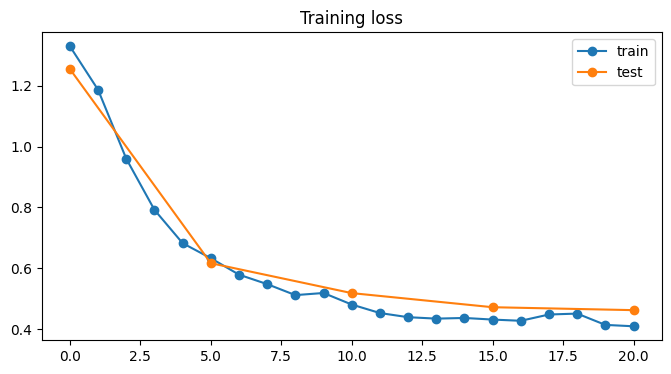

In [49]:
ds_train = util.PaddedTextVectorDataset( # custom class
    data_train["description"],
    data_train["target"],
    corpus_dict,
    max_vector_len=max_len,
)
ds_test = util.PaddedTextVectorDataset(
    data_test["description"],
    data_test["target"],
    corpus_dict,
    max_vector_len=max_len,
)
ds_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    corpus_dict,
    max_vector_len=max_len,
)

train_dl = DataLoader(ds_train, batch_size=512, shuffle=True)
test_dl = DataLoader(ds_test, batch_size=512, shuffle=False)
eval_dl = DataLoader(ds_eval, batch_size=512, shuffle=False)

vocab_size = len(corpus_dict.word_to_idx)
emb_dim = 4
n_hidden = 15
n_out = len(label_2_idx)

model = GRU(vocab_size, emb_dim, n_hidden, n_out)
opt = optim.Adam(model.parameters(), 1e-2)

train_losses, test_losses = util.fit(
    model=model,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_fn=F.cross_entropy,
    opt=opt,
    epochs=21
)
torch.save(model, "models/gru")

In [50]:
test_dl = DataLoader(ds_test, batch_size=1, shuffle=False)
eval_dl = DataLoader(ds_eval, batch_size=1, shuffle=False)

_, y_pred_test_gru, y_pred_prob_test_gru = util.predict(model, test_dl)
scores["gru"] = balanced_accuracy_score(
    data_test["category"],
    list(map(lambda x: idx_2_label[x], y_pred_test_gru))
)
print("Balanced accuracy score: {:.1f}%".format(scores["gru"] * 100))

Balanced accuracy score: 85.1%


In [51]:
_, _, y_pred_prob_eval_gru = util.predict(model, eval_dl)

eval_pred_gru = val.predict_labels(y_test_baseline, y_pred_prob_test_gru,
                                   y_pred_prob_eval_gru, np.array(idx_2_label))
eval_auto_gru = val.predict_labels(y_test_baseline, y_pred_prob_test_gru,
                                   y_pred_prob_eval_gru, np.array(idx_2_label), 0.999)
vis.show_predicted_labels_distribution(eval_pred_gru, "GRU")

Inference time estimation

In [52]:
%%time
tic = datetime.now()
ds_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    corpus_dict
)
eval_dl = DataLoader(ds_eval, batch_size=1, shuffle=False)
_, _, y_pred_prob_eval_gru = util.predict(model, eval_dl)

inference_time_s["gru"] = (datetime.now() - tic).total_seconds()

CPU times: user 5.12 s, sys: 23.2 ms, total: 5.14 s
Wall time: 5.16 s


### GRU / LSTM + pretrained embeddings

In [53]:
class LSTMPretrained(nn.Module):
    def __init__(self, n_hidden, n_out):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.emb.requires_grad_ = False
        self.embedding_dim = 300
        
        self.n_hidden = n_hidden
        self.n_out = n_out

        self.lstm = nn.LSTM(self.embedding_dim, self.n_hidden, num_layers=1)
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, sequence, lengths):
        batch_size = sequence.size(1)
        self.hidden = self.init_hidden(batch_size)
        embs = self.emb(sequence)
        embs = pack_padded_sequence(embs, lengths, enforce_sorted=True)
        lstm_out, (self.hidden, _) = self.lstm(embs)
        lstm_out, lengths = pad_packed_sequence(lstm_out)
        dropout = self.dropout(self.hidden[-1])
        output = self.out(dropout)
        return F.log_softmax(output, dim=-1)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros((1, batch_size, self.n_hidden)))

Train loss:	0.1827
Val loss:	0.2285


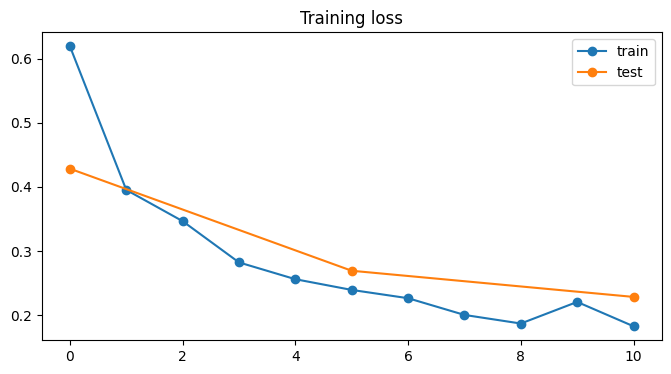

In [54]:
ds_emb_train = util.PaddedTextVectorDataset(
    data_train["description"],
    data_train["target"],
    emb=glove,
    max_vector_len=max_len,
)
ds_emb_test = util.PaddedTextVectorDataset(
    data_test["description"],
    data_test["target"],
    emb=glove,
    max_vector_len=max_len,
)
ds_emb_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    emb=glove,
    max_vector_len=max_len,
)

dl_emb_train = DataLoader(ds_emb_train, batch_size=512, shuffle=True)
dl_emb_test = DataLoader(ds_emb_test, batch_size=512, shuffle=False)
dl_emb_eval = DataLoader(ds_emb_eval, batch_size=512, shuffle=False)

n_hidden = 50
n_out = len(label_2_idx)

emb_model = LSTMPretrained(n_hidden, n_out)
opt = optim.Adam(emb_model.parameters(), 1e-2)

train_losses, test_losses = util.fit(model=emb_model, train_dl=dl_emb_train, test_dl=dl_emb_test,
         loss_fn=F.cross_entropy, opt=opt, epochs=11)
torch.save(emb_model, "models/lstm_pretrained_emb")

In [55]:
dl_emb_test = DataLoader(ds_emb_test, batch_size=1, shuffle=False)
dl_emb_eval = DataLoader(ds_emb_eval, batch_size=1, shuffle=False)

y_true_emb_test, y_pred_emb_test, y_pred_prob_emb_test = util.predict(emb_model, dl_emb_test)
scores["lstm+emb"] = balanced_accuracy_score(
    np.argmax(y_true_emb_test, axis=1),
    y_pred_emb_test
)
print("Balanced accuracy score: {:.1f}%".format(scores["lstm+emb"] * 100))

Balanced accuracy score: 93.7%


In [56]:
_, _, y_pred_prob_eval_emb = util.predict(emb_model, dl_emb_eval)

eval_pred_emb = val.predict_labels(y_test_baseline, y_pred_prob_emb_test,
                                   y_pred_prob_eval_emb, np.array(idx_2_label))
eval_auto_emb = val.predict_labels(y_test_baseline, y_pred_prob_emb_test,
                                   y_pred_prob_eval_emb, np.array(idx_2_label), 0.99)
vis.show_predicted_labels_distribution(eval_pred_emb, "LSTM + pretrained embs")

Inference time estimation

In [57]:
%%time
tic = datetime.now()
ds_emb_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    emb=glove
)
dl_emb_eval = DataLoader(ds_emb_eval, batch_size=1, shuffle=False)
_ = util.predict(emb_model, dl_emb_eval)
inference_time_s["lstm+emb"] = (datetime.now() - tic).total_seconds()

CPU times: user 5.03 s, sys: 164 ms, total: 5.2 s
Wall time: 5.22 s


### BERT

In [58]:
ds_train_bert = bert.get_dataset(
    list(data_train["description"]),
    list(data_train["target"]),
    max_vector_len=64
)
ds_test_bert = bert.get_dataset(
    list(data_test["description"]),
    list(data_test["target"]),
    max_vector_len=64
)
ds_eval_bert = bert.get_dataset(
    list(data_eval["description"]),
    list(data_eval["target"]),
    max_vector_len=64
)

In [59]:
batch_size = 64

dl_train_bert = DataLoader(ds_train_bert, sampler=RandomSampler(ds_train_bert), batch_size=batch_size)
dl_test_bert = DataLoader(ds_test_bert, sampler=SequentialSampler(ds_test_bert), batch_size=batch_size)
dl_eval_bert = DataLoader(ds_eval_bert, sampler=SequentialSampler(ds_eval_bert), batch_size=batch_size)

In [60]:
if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [61]:
b_model = bert.BERTModel(n_out=4)
b_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTModel(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [62]:
params = list(b_model.named_parameters())

print("Embedding Layer:")
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\nFirst Transformer")

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\nOutput Layer")

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Embedding Layer:
l1.embeddings.word_embeddings.weight                    (30522, 768)
l1.embeddings.position_embeddings.weight                  (512, 768)
l1.embeddings.token_type_embeddings.weight                  (2, 768)
l1.embeddings.LayerNorm.weight                                (768,)
l1.embeddings.LayerNorm.bias                                  (768,)

First Transformer
l1.encoder.layer.0.attention.self.query.weight            (768, 768)
l1.encoder.layer.0.attention.self.query.bias                  (768,)
l1.encoder.layer.0.attention.self.key.weight              (768, 768)
l1.encoder.layer.0.attention.self.key.bias                    (768,)
l1.encoder.layer.0.attention.self.value.weight            (768, 768)
l1.encoder.layer.0.attention.self.value.bias                  (768,)
l1.encoder.layer.0.attention.output.dense.weight          (768, 768)
l1.encoder.layer.0.attention.output.dense.bias                (768,)
l1.encoder.layer.0.attention.output.LayerNorm.weight          (768,

In [63]:
optimizer = optim.AdamW(b_model.parameters(), lr=2e-5, eps=1e-8)

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [64]:
epochs = 2
total_steps = len(dl_train_bert) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=total_steps
)
print(f"Total steps: {total_steps}")

Total steps: 610


In [65]:
bert.fit(b_model, dl_train_bert, dl_test_bert, optimizer, scheduler, loss_fn, device, epochs=epochs)
torch.save(b_model, "models/bert_fine_tuned")

2024-03-03 14:15:10.808611	Epoch 1 / 2
Training...
2024-03-03 14:17:40.838341	step 40 / 305 done
2024-03-03 14:20:14.857773	step 80 / 305 done
2024-03-03 14:22:48.736802	step 120 / 305 done
2024-03-03 14:25:13.014470	step 160 / 305 done
2024-03-03 14:27:44.785613	step 200 / 305 done
2024-03-03 14:30:18.897717	step 240 / 305 done
2024-03-03 14:32:55.940922	step 280 / 305 done
2024-03-03 14:34:24.123007	Average training loss: 0.18

2024-03-03 14:34:24.123525	Validating...
2024-03-03 14:35:27.273090	Average validation loss: 0.10

2024-03-03 14:35:27.273182	Epoch 2 / 2
Training...
2024-03-03 14:38:06.132608	step 40 / 305 done
2024-03-03 14:40:34.198344	step 80 / 305 done
2024-03-03 14:43:09.208080	step 120 / 305 done
2024-03-03 14:45:44.655376	step 160 / 305 done
2024-03-03 14:48:08.364332	step 200 / 305 done
2024-03-03 14:50:32.822048	step 240 / 305 done
2024-03-03 14:53:01.858647	step 280 / 305 done
2024-03-03 14:54:30.465787	Average training loss: 0.08

2024-03-03 14:54:30.466324	Valida

In [66]:
%%time
_, y_pred_prob_test_bert = bert.predict(b_model, dl_test_bert, device)

CPU times: user 3min 36s, sys: 34.9 s, total: 4min 11s
Wall time: 1min 2s


In [67]:
scores["bert"] = balanced_accuracy_score(
    data_test["category"],
    list(map(lambda x: idx_2_label[x], np.argmax(y_pred_prob_test_bert, axis=1)))
)
print("Balanced accuracy score: {:.1f}%".format(scores["bert"] * 100))

Balanced accuracy score: 95.1%


In [68]:
_, y_pred_prob_eval_bert = bert.predict(b_model, dl_eval_bert, device)

eval_pred_bert = val.predict_labels(y_test_baseline, y_pred_prob_test_bert,
                                    y_pred_prob_eval_bert, np.array(idx_2_label))
eval_auto_bert = val.predict_labels(y_test_baseline, y_pred_prob_test_bert,
                                    y_pred_prob_eval_bert, np.array(idx_2_label), 0.999)
vis.show_predicted_labels_distribution(eval_pred_bert, "BERT fine-tuned")

Inference time estimation

In [69]:
%%time
tic = datetime.now()
ds_eval_bert = bert.get_dataset(
    list(data_eval["description"]),
    list(data_eval["target"]),
    max_vector_len=64
)
dl_eval_bert = DataLoader(ds_eval_bert, sampler=SequentialSampler(ds_eval_bert), batch_size=batch_size)
_ = bert.predict(b_model, dl_eval_bert, device)
inference_time_s["bert"] = (datetime.now() - tic).total_seconds()

CPU times: user 3min 41s, sys: 33.5 s, total: 4min 14s
Wall time: 1min 8s


## Choosing the model

Quality

In [70]:
print(
    "Balanced accuracy scores\n{}".format(
        "\n".join(["{}: {:.1f}%".format(method, score * 100) for method, score in scores.items()])
    )
)

Balanced accuracy scores
baseline: 79.8%
gru: 85.1%
lstm+emb: 93.7%
bert: 95.1%


Inference times

In [71]:
inference_time = pd.DataFrame({
    "sec": list(inference_time_s.values()),
    "method": list(map(lambda x: x.upper(), inference_time_s.keys()))
})
inference_time["secs_per_message"] = inference_time["sec"] / data_eval.shape[0]

print("Inference time per message estimation:\n{}".format(inference_time))

Inference time per message estimation:
         sec    method  secs_per_message
0   0.186754  BASELINE          0.000045
1   5.161665       GRU          0.001238
2   5.218329  LSTM+EMB          0.001251
3  68.841768      BERT          0.016505


## Mislabelling examples

In [72]:
for i, (label_true, label_pred) in enumerate(zip(data_eval["category"], eval_pred_emb)):
    if label_true != label_pred and label_pred != "UNK":
        print("Idx: {}\nTrue: {}\nPredicted: {}\nDescription:\n{}\n\n".format(
            i,
            label_true,
            label_pred,
            data_eval["description"].iloc[i]
        ))

Idx: 2
True: Household
Predicted: Books
Description:
Pragati Pro flower basket diary Pragati Pro flower basket diary


Idx: 25
True: Electronics
Predicted: Household
Description:
ZOZO [4+1] Premium Plastic Auto Trim Removal Multi-Use and Rust Free Stainless Steel Fastener Remover Combination Set Car Dash Audio Radio Door Panel Repair Installer Open Pry Tool Powseed 5pcs Multi-use Removal Tool Set FASTENER REMOVER Rust Free Design + Plastic. Large handle for comfort using. Easy Carry. Plastic Panel Removal Tool 4 pcs Made from Premium Plastic, Strong and Tough. Multi-use panel tools apply anywhere inside or outside your vehicle space and crevices that hard to reach.


Idx: 31
True: Electronics
Predicted: Household
Description:
Inditradition Hand Paper Shredder/Paper Cutter With Steel Blades for A4 & A5 Sheets This Mini Paper Shredder is a clean alternative to destroying confidential papers and family documents. It is operated by the simple turn of the rotating handle and it shreds paper